In [1]:
"""Multi-threaded word2vec unbatched skip-gram model.
Trains the model described in:
(Mikolov, et. al.) Efficient Estimation of Word Representations in Vector Space
ICLR 2013.
http://arxiv.org/abs/1301.3781
This model does true SGD (i.e. no minibatching). To do this efficiently, custom
ops are used to sequentially process data within a 'batch'.
The key ops used are:
* skipgram custom op that does input processing.
* neg_train custom op that efficiently calculates and applies the gradient using
  true SGD.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import threading
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from random import choice, shuffle
from matplotlib import pylab
import pickle
%matplotlib inline

from six.moves import xrange  # pylint: disable=redefined-builtin

import numpy as np
from numpy import array
import pandas as pd
import tensorflow as tf

from tensorflow.models.embedding import gen_word2vec as word2vec

flags = tf.app.flags

flags.DEFINE_string("save_path", "./mdl", "Directory to write the model.")
flags.DEFINE_string( ## /Users/orpaz/Desktop/CS269_Relational_learning/project/20_newsgroups/sci.space/outfull
    "train_data", "./text8",
    "Training data. E.g., unzipped file http://mattmahoney.net/dc/text8.zip.")
flags.DEFINE_string(
    "eval_data", "./word2vec/trunk/questions-words.txt", "Analogy questions. "
    "See README.md for how to get 'questions-words.txt'.")
flags.DEFINE_integer("embedding_size", 200, "The embedding dimension size.")
flags.DEFINE_integer(
    "epochs_to_train", 40,
    "Number of epochs to train. Each epoch processes the training data once "
    "completely.")
flags.DEFINE_float("learning_rate", 0.025, "Initial learning rate.")
flags.DEFINE_integer("num_neg_samples", 25,
                     "Negative samples per training example.")
flags.DEFINE_integer("batch_size", 50,
                     "Numbers of training examples each step processes "
                     "(no minibatching).")
flags.DEFINE_integer("concurrent_steps", 12,
                     "The number of concurrent training steps.")
flags.DEFINE_integer("window_size", 5,
                     "The number of words to predict to the left and right "
                     "of the target word.")
flags.DEFINE_integer("min_count", 5,
                     "The minimum number of word occurrences for it to be "
                     "included in the vocabulary.")
flags.DEFINE_float("subsample", 1e-3,
                   "Subsample threshold for word occurrence. Words that appear "
                   "with higher frequency will be randomly down-sampled. Set "
                   "to 0 to disable.")
flags.DEFINE_boolean(
    "interactive", False,
    "If true, enters an IPython interactive session to play with the trained "
    "model. E.g., try model.analogy(b'france', b'paris', b'russia') and "
    "model.nearby([b'proton', b'elephant', b'maxwell'])")

FLAGS = flags.FLAGS


In [2]:
class Options(object):
  """Options used by our word2vec model."""

  def __init__(self):
    # Model options.

    # Embedding dimension.
    self.emb_dim = FLAGS.embedding_size

    # Training options.

    # The training text file.
    self.train_data = FLAGS.train_data

    # Number of negative samples per example.
    self.num_samples = FLAGS.num_neg_samples

    # The initial learning rate.
    self.learning_rate = FLAGS.learning_rate

    # Number of epochs to train. After these many epochs, the learning
    # rate decays linearly to zero and the training stops.
    self.epochs_to_train = FLAGS.epochs_to_train

    # Concurrent training steps.
    self.concurrent_steps = FLAGS.concurrent_steps

    # Number of examples for one training step.
    self.batch_size = FLAGS.batch_size

    # The number of words to predict to the left and right of the target word.
    self.window_size = FLAGS.window_size

    # The minimum number of word occurrences for it to be included in the
    # vocabulary.
    self.min_count = FLAGS.min_count

    # Subsampling threshold for word occurrence.
    self.subsample = FLAGS.subsample

    # Where to write out summaries.
    self.save_path = FLAGS.save_path

    # Eval options.

    # The text file for eval.
    self.eval_data = FLAGS.eval_data

In [3]:
class Word2Vec(object):
  """Word2Vec model (Skipgram)."""

  def __init__(self, options, session):
    self._options = options
    self._session = session
    self._word2id = {}
    self._id2word = []
    self.build_graph()
    self.build_eval_graph()
    self.save_vocab()

  def read_analogies(self):
    """Reads through the analogy question file.
    Returns:
      questions: a [n, 4] numpy array containing the analogy question's
                 word ids.
      questions_skipped: questions skipped due to unknown words.
    """
    questions = []
    questions_skipped = 0
    with open(self._options.eval_data, "rb") as analogy_f:
      for line in analogy_f:
        if line.startswith(b":"):  # Skip comments.
          continue
        words = line.strip().lower().split(b" ")
        ids = [self._word2id.get(w.strip()) for w in words]
        if None in ids or len(ids) != 4:
          questions_skipped += 1
        else:
          questions.append(np.array(ids))
    print("Eval analogy file: ", self._options.eval_data)
    print("Questions: ", len(questions))
    print("Skipped: ", questions_skipped)
    self._analogy_questions = np.array(questions, dtype=np.int32)

  def build_graph(self):
    """Build the model graph."""
    opts = self._options

    # The training data. A text file.
    (words, counts, words_per_epoch, current_epoch, total_words_processed,
     examples, labels) = word2vec.skipgram(filename=opts.train_data,
                                           batch_size=opts.batch_size,
                                           window_size=opts.window_size,
                                           min_count=opts.min_count,
                                           subsample=opts.subsample)
    (opts.vocab_words, opts.vocab_counts,
     opts.words_per_epoch) = self._session.run([words, counts, words_per_epoch])
    opts.vocab_size = len(opts.vocab_words)
    print("Data file: ", opts.train_data)
    print("Vocab size: ", opts.vocab_size - 1, " + UNK")
    print("Words per epoch: ", opts.words_per_epoch)

    self._id2word = opts.vocab_words
    for i, w in enumerate(self._id2word):
      self._word2id[w] = i

    # Declare all variables we need.
    # Input words embedding: [vocab_size, emb_dim]
    w_in = tf.Variable(
        tf.random_uniform(
            [opts.vocab_size,
             opts.emb_dim], -0.5 / opts.emb_dim, 0.5 / opts.emb_dim),
        name="w_in")

    # Global step: scalar, i.e., shape [].
    w_out = tf.Variable(tf.zeros([opts.vocab_size, opts.emb_dim]), name="w_out")

    # Global step: []
    global_step = tf.Variable(0, name="global_step")

    # Linear learning rate decay.
    words_to_train = float(opts.words_per_epoch * opts.epochs_to_train)
    lr = opts.learning_rate * tf.maximum(
        0.0001,
        1.0 - tf.cast(total_words_processed, tf.float32) / words_to_train)

    # Training nodes.
    inc = global_step.assign_add(1)
    with tf.control_dependencies([inc]):
      train = word2vec.neg_train(w_in,
                                 w_out,
                                 examples,
                                 labels,
                                 lr,
                                 vocab_count=opts.vocab_counts.tolist(),
                                 num_negative_samples=opts.num_samples)

    self._w_in = w_in
    self._examples = examples
    self._labels = labels
    self._lr = lr
    self._train = train
    self.global_step = global_step
    self._epoch = current_epoch
    self._words = total_words_processed

  def save_vocab(self):
    """Save the vocabulary to a file so the model can be reloaded."""
    opts = self._options
    with open(os.path.join(opts.save_path, "vocab.txt"), "w") as f:
      for i in xrange(opts.vocab_size):
        vocab_word = tf.compat.as_text(opts.vocab_words[i]).encode("utf-8")
        f.write("%s %d\n" % (vocab_word,
                             opts.vocab_counts[i]))

  def build_eval_graph(self):
    """Build the evaluation graph."""
    # Eval graph
    opts = self._options

    # Each analogy task is to predict the 4th word (d) given three
    # words: a, b, c.  E.g., a=italy, b=rome, c=france, we should
    # predict d=paris.

    # The eval feeds three vectors of word ids for a, b, c, each of
    # which is of size N, where N is the number of analogies we want to
    # evaluate in one batch.
    analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
    analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
    analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

    # Normalized word embeddings of shape [vocab_size, emb_dim].
    nemb = tf.nn.l2_normalize(self._w_in, 1)

    # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
    # They all have the shape [N, emb_dim]
    a_emb = tf.gather(nemb, analogy_a)  # a's embs
    b_emb = tf.gather(nemb, analogy_b)  # b's embs
    c_emb = tf.gather(nemb, analogy_c)  # c's embs

    # We expect that d's embedding vectors on the unit hyper-sphere is
    # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
    target = c_emb + (b_emb - a_emb)

    # Compute cosine distance between each pair of target and vocab.
    # dist has shape [N, vocab_size].
    dist = tf.matmul(target, nemb, transpose_b=True)

    # For each question (row in dist), find the top 4 words.
    _, pred_idx = tf.nn.top_k(dist, 4)

    # Nodes for computing neighbors for a given word according to
    # their cosine distance.
    nearby_word = tf.placeholder(dtype=tf.int32)  # word id
    nearby_emb = tf.gather(nemb, nearby_word)
    nearby_dist = tf.matmul(nearby_emb, nemb, transpose_b=True)
    nearby_val, nearby_idx = tf.nn.top_k(nearby_dist,
                                         min(1000, opts.vocab_size))

    # Nodes in the construct graph which are used by training and
    # evaluation to run/feed/fetch.
    self._analogy_a = analogy_a
    self._analogy_b = analogy_b
    self._analogy_c = analogy_c
    self._analogy_pred_idx = pred_idx
    self._nearby_word = nearby_word
    self._nearby_val = nearby_val
    self._nearby_idx = nearby_idx

    # Properly initialize all variables.
    tf.initialize_all_variables().run()

    self.saver = tf.train.Saver()

  def _train_thread_body(self):
    initial_epoch, = self._session.run([self._epoch])
    while True:
      _, epoch = self._session.run([self._train, self._epoch])
      if epoch != initial_epoch:
        break

  def train(self):
    """Train the model."""
    opts = self._options

    initial_epoch, initial_words = self._session.run([self._epoch, self._words])

    workers = []
    for _ in xrange(opts.concurrent_steps):
      t = threading.Thread(target=self._train_thread_body)
      t.start()
      workers.append(t)

    last_words, last_time = initial_words, time.time()
    while True:
      time.sleep(5)  # Reports our progress once a while.
      (epoch, step, words, lr) = self._session.run(
          [self._epoch, self.global_step, self._words, self._lr])
      now = time.time()
      last_words, last_time, rate = words, now, (words - last_words) / (
          now - last_time)
      print("Epoch %4d Step %8d: lr = %5.3f words/sec = %8.0f\r" % (epoch, step,
                                                                    lr, rate),
            end="")
      sys.stdout.flush()
      if epoch != initial_epoch:
        break

    for t in workers:
      t.join()

  def _predict(self, analogy):
    """Predict the top 4 answers for analogy questions."""
    idx, = self._session.run([self._analogy_pred_idx], {
        self._analogy_a: analogy[:, 0],
        self._analogy_b: analogy[:, 1],
        self._analogy_c: analogy[:, 2]
    })
    return idx

  def eval(self):
    """Evaluate analogy questions and reports accuracy."""

    # How many questions we get right at precision@1.
    correct = 0

    try:
      total = self._analogy_questions.shape[0]
    except AttributeError as e:
      raise AttributeError("Need to read analogy questions.")

    start = 0
    while start < total:
      limit = start + 2500
      sub = self._analogy_questions[start:limit, :]
      idx = self._predict(sub)
      start = limit
      for question in xrange(sub.shape[0]):
        for j in xrange(4):
          if idx[question, j] == sub[question, 3]:
            # Bingo! We predicted correctly. E.g., [italy, rome, france, paris].
            correct += 1
            break
          elif idx[question, j] in sub[question, :3]:
            # We need to skip words already in the question.
            continue
          else:
            # The correct label is not the precision@1
            break
    print()
    print("Eval %4d/%d accuracy = %4.1f%%" % (correct, total,
                                              correct * 100.0 / total))

  def analogy(self, w0, w1, w2):
    """Predict word w3 as in w0:w1 vs w2:w3."""
    wid = np.array([[self._word2id.get(w, 0) for w in [w0, w1, w2]]])
    idx = self._predict(wid)
    for c in [self._id2word[i] for i in idx[0, :]]:
      if c not in [w0, w1, w2]:
        print(c)
        return w2,c
    print("unknown")

  def nearby(self, words, num=20):
    """Prints out nearby words given a list of words."""
    ids = np.array([self._word2id.get(x, 0) for x in words])
    vals, idx = self._session.run(
        [self._nearby_val, self._nearby_idx], {self._nearby_word: ids})
    for i in xrange(len(words)):
      print("\n%s\n=====================================" % (words[i]))
      for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
        print("%-20s %6.4f" % (self._id2word[neighbor], distance))
    return idx
 
  def kMeansCluster(self, num_clusters, max_num_steps, stop_coeficient = 0.0):
      vectors = tf.constant(self._w_in.eval())
      centroids = tf.Variable(tf.slice(tf.random_shuffle(vectors),
                                       [0,0],[num_clusters,-1]))
      dim = opts.emb_dim
    
      old_centroids = tf.Variable(tf.zeros([num_clusters,dim]))
      centroid_distance = tf.Variable(tf.zeros([num_clusters,dim]))

      expanded_vectors = tf.expand_dims(vectors, 0)
      expanded_centroids = tf.expand_dims(centroids, 1)

      print (expanded_vectors.get_shape())
      print (expanded_centroids.get_shape())

      distances = tf.reduce_sum(
        tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
      assignments = tf.argmin(distances, 0)

      means = tf.concat(0, [
        tf.reduce_mean(
            tf.gather(vectors,
                      tf.reshape(
                        tf.where(
                          tf.equal(assignments, c)
                        ),[1,-1])
                     ),reduction_indices=[1])
        for c in xrange(num_clusters)])

      save_old_centroids = tf.assign(old_centroids, centroids)

      update_centroids = tf.assign(centroids, means)
      init_op = tf.initialize_all_variables()

      performance = tf.assign(centroid_distance, tf.sub(centroids, old_centroids))
      check_stop = tf.reduce_sum(tf.abs(performance))

      with tf.Session() as sess:
        sess.run(init_op)
        for step in xrange(max_num_steps):
          print ("Running step " + str(step))
          sess.run(save_old_centroids)
          _, centroid_values, assignment_values = sess.run([update_centroids,
                                                            centroids,
                                                            assignments])
          sess.run(check_stop)
          current_stop_coeficient = check_stop.eval()
          print ("coeficient:", current_stop_coeficient)
          if current_stop_coeficient <= stop_coeficient:
            break
        
      return centroid_values, assignment_values

  def TFKMeansCluster(self, noofclusters):
    """
    K-Means Clustering using TensorFlow.
    'vectors' should be a n*k 2-D NumPy array, where n is the number
    of vectors of dimensionality k.
    'noofclusters' should be an integer.
    """
    
    vectors = self._w_in.eval()
    noofclusters = int(noofclusters)
    assert noofclusters < len(vectors)
 
    #Find out the dimensionality
    dim = opts.emb_dim
 
    #Will help select random centroids from among the available vectors
    vector_indices = list(range(len(vectors)))
    shuffle(vector_indices)
 
    #GRAPH OF COMPUTATION
    #We initialize a new graph and set it as the default during each run
    #of this algorithm. This ensures that as this function is called
    #multiple times, the default graph doesn't keep getting crowded with
    #unused ops and Variables from previous function calls.
 
    graph = tf.Graph()
 
    with graph.as_default():
 
        #SESSION OF COMPUTATION
 
        sess = tf.Session()
 
        ##CONSTRUCTING THE ELEMENTS OF COMPUTATION
 
        ##First lets ensure we have a Variable vector for each centroid,
        ##initialized to one of the vectors from the available data points
        centroids = [tf.Variable((vectors[vector_indices[i]]))
                     for i in range(noofclusters)]
        ##These nodes will assign the centroid Variables the appropriate
        ##values
        centroid_value = tf.placeholder("float32", [dim])
        cent_assigns = []
        for centroid in centroids:
            cent_assigns.append(tf.assign(centroid, centroid_value))
 
        ##Variables for cluster assignments of individual vectors(initialized
        ##to 0 at first)
        assignments = [tf.Variable(0) for i in range(len(vectors))]
        ##These nodes will assign an assignment Variable the appropriate
        ##value
        assignment_value = tf.placeholder("int32")
        cluster_assigns = []
        for assignment in assignments:
            cluster_assigns.append(tf.assign(assignment,
                                             assignment_value))
 
        ##Now lets construct the node that will compute the mean
        #The placeholder for the input
        mean_input = tf.placeholder("float", [None, dim])
        #The Node/op takes the input and computes a mean along the 0th
        #dimension, i.e. the list of input vectors
        mean_op = tf.reduce_mean(mean_input, 0)
 
        ##Node for computing Euclidean distances
        #Placeholders for input
        v1 = tf.placeholder("float", [dim])
        v2 = tf.placeholder("float", [dim])
        euclid_dist = tf.sqrt(tf.reduce_sum(tf.pow(tf.sub(
            v1, v2), 2)))
 
        ##This node will figure out which cluster to assign a vector to,
        ##based on Euclidean distances of the vector from the centroids.
        #Placeholder for input
        centroid_distances = tf.placeholder("float", [noofclusters])
        cluster_assignment = tf.argmin(centroid_distances, 0)
 
        ##INITIALIZING STATE VARIABLES
 
        ##This will help initialization of all Variables defined with respect
        ##to the graph. The Variable-initializer should be defined after
        ##all the Variables have been constructed, so that each of them
        ##will be included in the initialization.
        init_op = tf.initialize_all_variables()
 
        #Initialize all variables
        sess.run(init_op)
 
        ##CLUSTERING ITERATIONS
 
        #Now perform the Expectation-Maximization steps of K-Means clustering
        #iterations. To keep things simple, we will only do a set number of
        #iterations, instead of using a Stopping Criterion.
        noofiterations = 100
        for iteration_n in range(noofiterations):
 
            ##EXPECTATION STEP
            ##Based on the centroid locations till last iteration, compute
            ##the _expected_ centroid assignments.
            #Iterate over each vector
            for vector_n in range(len(vectors)):
                vect = vectors[vector_n]
                #Compute Euclidean distance between this vector and each
                #centroid. Remember that this list cannot be named
                #'centroid_distances', since that is the input to the
                #cluster assignment node.
                distances = [sess.run(euclid_dist, feed_dict={
                    v1: vect, v2: sess.run(centroid)})
                             for centroid in centroids]
                #Now use the cluster assignment node, with the distances
                #as the input
                assignment = sess.run(cluster_assignment, feed_dict = {
                    centroid_distances: distances})
                #Now assign the value to the appropriate state variable
                sess.run(cluster_assigns[vector_n], feed_dict={
                    assignment_value: assignment})
 
            ##MAXIMIZATION STEP
            #Based on the expected state computed from the Expectation Step,
            #compute the locations of the centroids so as to maximize the
            #overall objective of minimizing within-cluster Sum-of-Squares
            for cluster_n in range(noofclusters):
                #Collect all the vectors assigned to this cluster
                assigned_vects = [vectors[i] for i in range(len(vectors))
                                  if sess.run(assignments[i]) == cluster_n]
                #Compute new centroid location
                new_location = sess.run(mean_op, feed_dict={
                    mean_input: array(assigned_vects)})
                #Assign value to appropriate variable
                sess.run(cent_assigns[cluster_n], feed_dict={
                    centroid_value: new_location})
 
        #Return centroids and assignments
        centroids = sess.run(centroids)
        assignments = sess.run(assignments)
        return centroids, assignments
    
  def k_means(self):   
    K=500
    MAX_ITERS = 10
    opts = self._options
    
    start = time.time()
    
    # Normalized word embeddings of shape [vocab_size, emb_dim].
    #nemb = tf.nn.l2_normalize(self._w_in, 1)
    #points = tf.Variable(tf.random_uniform([N,2]))
    points = self._w_in.eval()
    cluster_assignments = tf.Variable(tf.zeros([opts.vocab_size], dtype=tf.int64))

    # Silly initialization:  Use the first K points as the starting
    # centroids.  In the real world, do this better.
    centroids = tf.Variable(tf.slice(points, [0,0], [K,opts.emb_dim]))

    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [opts.vocab_size, 1]), [opts.vocab_size, K, opts.emb_dim])
    rep_points = tf.reshape(tf.tile(points, [1, K]), [opts.vocab_size, K, opts.emb_dim])
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), reduction_indices=2)

    # Use argmin to select the lowest-distance point
    best_centroids = tf.argmin(sum_squares, 1)
    did_assignments_change = tf.reduce_any(tf.not_equal(best_centroids, 
                                                        cluster_assignments))

    def bucket_mean(data, bucket_ids, num_buckets):
        total = tf.unsorted_segment_sum(data, bucket_ids, num_buckets)
        count = tf.unsorted_segment_sum(tf.ones_like(data), bucket_ids, num_buckets)
        return total / count

    means = bucket_mean(points, best_centroids, K)

    # Do not write to the assigned clusters variable until after
    # computing whether the assignments have changed - hence with_dependencies
    with tf.control_dependencies([did_assignments_change]):
        do_updates = tf.group(
            centroids.assign(means),
            cluster_assignments.assign(best_centroids))

    init = tf.initialize_all_variables()

    self._session.run(init)

    changed = True
    iters = 0

    while changed and iters < MAX_ITERS:
        iters += 1
        [changed, _] = self._session.run([did_assignments_change, do_updates])

    [centers, assignments] = self._session.run([centroids, cluster_assignments])
    end = time.time()
    print ("Found in %.2f seconds" % (end-start)), iters, "iterations"
    #print ("Centroids:")
    #print (centers)
    #print ("Cluster assignments:", assignments)
    return centers, assignments

  def plot_k_means(self, centers = None):
    num_points = 500
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=1000)
    #nemb = tf.nn.l2_normalize(self._w_in, 1)
    two_d_embeddings = tsne.fit_transform(self._w_in.eval()[1:num_points+1, :])
    if centers is not None:
        two_d_centers = tsne.fit_transform(centers)

    def plot(embeddings, labels, centers = None):
        assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
        pylab.figure(figsize=(15,15))  # in inches
        if centers is not None:
            for c in centers:
                x, y = c
                pylab.scatter(x, y)
                pylab.annotate("Cluster_middle!!!", xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
            pylab.scatter(x, y)
        for i, label in enumerate(labels):
            x, y = embeddings[i,:]
            pylab.scatter(x, y)
            pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
        pylab.show()

    words = [model._id2word[i] for i in range(1, num_points+1)]
    if centers is not None:
        plot(two_d_embeddings, words, two_d_centers)
    else:
        plot(two_d_embeddings, words)

  def nearby_clusters(self, clusters, num=20):
    opts = self._options
    nemb = tf.nn.l2_normalize(self._w_in, 1)
    nearby_dist = tf.matmul(clusters, nemb, transpose_b=True)
    nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(1000, opts.vocab_size))
    
    tf.initialize_all_variables().run()
    vals, idx = self._session.run([nearby_val, nearby_idx])
       
    for i in xrange(len(clusters)):
      print("\n%s\n=====================================" % ("clusters:" + str(i)))
      for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
        print("%-20s %6.4f" % (self._id2word[neighbor], distance))
        
  def find_cluster_analogy(self, center1, center2, word):
    # Normalized word embeddings of shape [vocab_size, emb_dim].
    nemb = tf.nn.l2_normalize(self._w_in, 1)
    w = self._word2id.get(word, 0)
    # Each row of a_emb, b_emb, c_emb is a word's embedding vector.
    # They all have the shape [N, emb_dim]
    a_emb = center1
    b_emb = center2
    c_emb = tf.gather(nemb, w)  # c's embs

    # We expect that d's embedding vectors on the unit hyper-sphere is
    # near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
    target = c_emb + (b_emb - a_emb)
    target = tf.reshape(target,[1,-1])
    
    # Compute cosine distance between each pair of target and vocab.
    # dist has shape [N, vocab_size].
    dist = tf.matmul(target.eval(), nemb, transpose_b=True)

    # For each question (row in dist), find the top 4 words.
    _, pred_idx = tf.nn.top_k(dist, 4)
    for c in [self._id2word[i] for i in pred_idx.eval()[0, :]]:
      #if c not in [w0, w1, w2]:
        print(c)



### Plot resulting vector space 

Data file:  ./text8
Vocab size:  71290  + UNK
Words per epoch:  17005207


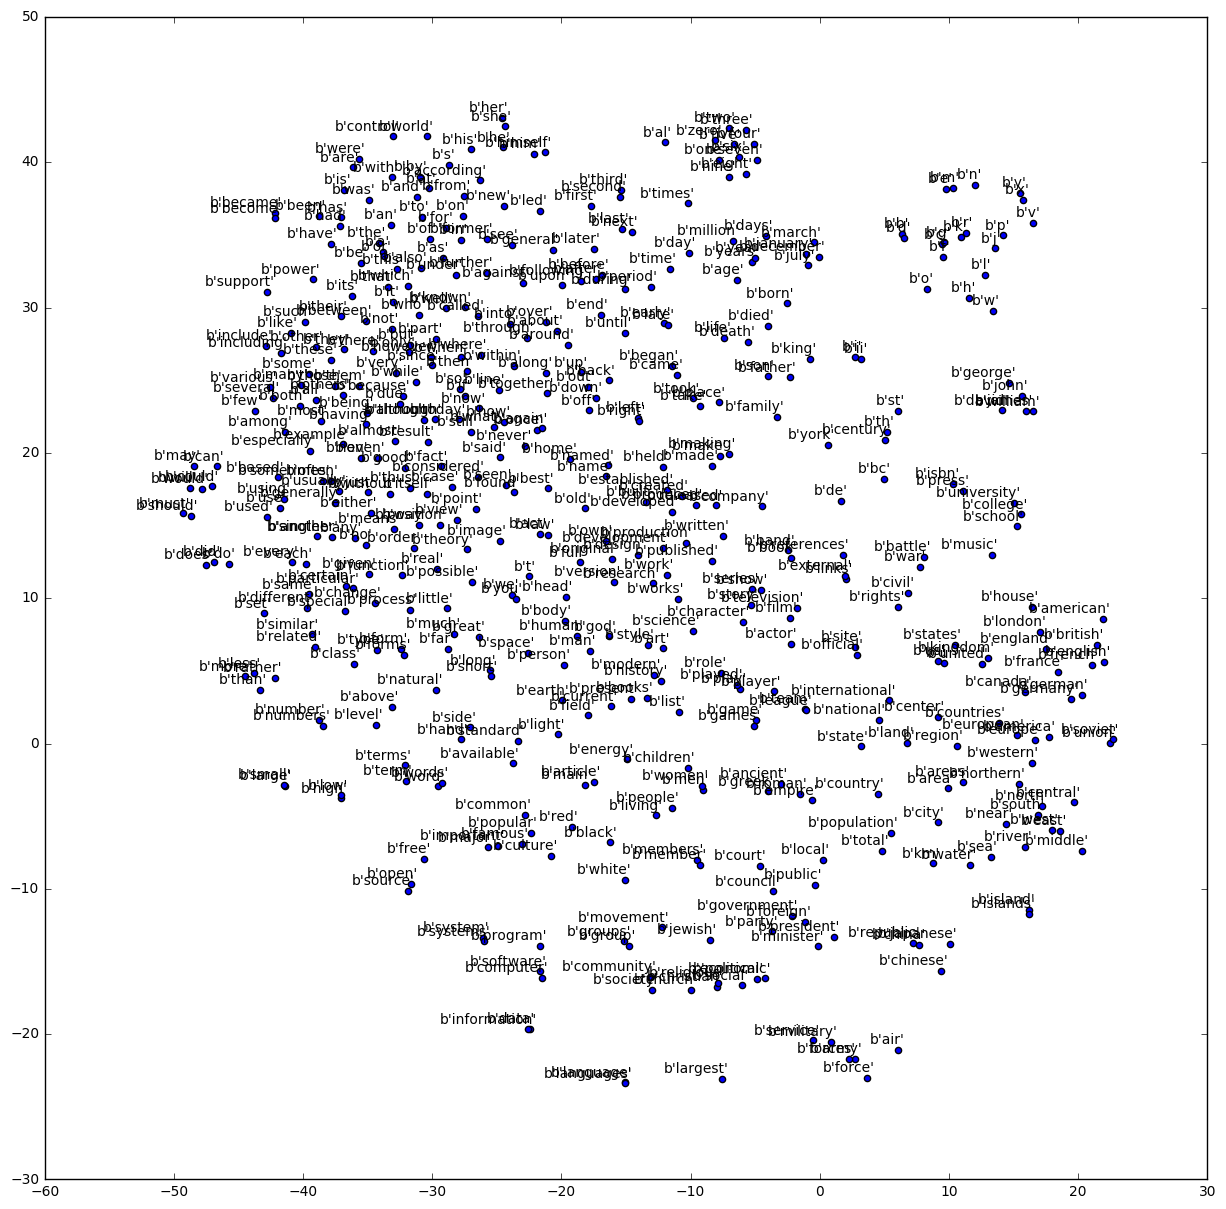

In [5]:
opts = Options()
with tf.Graph().as_default(), tf.Session() as session:
    model = Word2Vec(opts, session)
    model.saver.restore(session, os.path.join(opts.save_path, "model.ckpt-15092945"))
    model.plot_k_means()



### Clustering, Dimension reduction and cross cluster vector extraction

In [ ]:
import random
opts = Options()
temp = []
with tf.Graph().as_default(), tf.Session() as session:
    model = Word2Vec(opts, session)
    model.saver.restore(session, os.path.join(opts.save_path, "model.ckpt-15092945"))
    temp = model._w_in.eval()[res]
    pca = PCA(n_components=None)
    pca.fit_transform(temp)

#     centers, assignments = model.kMeansCluster(200,40)
#     with open('centers_200_40.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#       pickle.dump(centers, f, pickle.HIGHEST_PROTOCOL)
#     with open('assignments_200_40.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#       pickle.dump(assignments, f, pickle.HIGHEST_PROTOCOL)
#     model.plot_k_means(centers)
#     print(model._w_in.eval()[1:3])
#     model.nearby_clusters(centers)
#    model.find_cluster_analogy(centers[208], centers[203], b'pilsner')

In [ ]:
pca.explained_variance_ratio_

### Loading predefined cluters

In [28]:
with open('centers_300_40.pickle', 'rb') as f:
# Pickle the 'data' dictionary using the highest protocol available.
  centers = pickle.load(f)
with open('assignments_300_40.pickle', 'rb') as f:
# Pickle the 'data' dictionary using the highest protocol available.
  assignments = pickle.load(f)

### In cluster extraction & Skip cluster extraction

In [61]:
import random
opts = Options()
temp = []
with tf.Graph().as_default(), tf.Session() as session:
    model = Word2Vec(opts, session)
    model.saver.restore(session, os.path.join(opts.save_path, "model.ckpt-15092945"))
#     temp = model._w_in.eval()[res]

#     for i in range(100):
#         a = model._id2word[random.choice(res[0])]
#         b = model._id2word[random.choice(res[0])]
#         c = model._id2word[random.choice(res[0])]
#         print(a,b,c)
#         model.analogy(a, b, c)

#     vals = model.nearby([b'russia'])
    a = model._id2word[random.choice(res[0])]
    b = model._id2word[random.choice(res[0])]
    for i in range(100):
        c = model._id2word[random.choice(res[0])]
        print(a,b,c)
        model.analogy(a, b, c)

#     for i in range(100):
#         a = b'russians'
#         b = b'vodka'
#         c = model._id2word[random.choice(vals[0])]
#         print(a,b,c)
#         model.analogy(a, b, c)

Data file:  ./text8
Vocab size:  71290  + UNK
Words per epoch:  17005207
b'milkshake' b'tequila' b'yum'
b'moshi'
b'milkshake' b'tequila' b'stewed'
b'beiderbecke'
b'milkshake' b'tequila' b'garnishes'
b'cobblers'
b'milkshake' b'tequila' b'matzoh'
b'discernable'
b'milkshake' b'tequila' b'mash'
b'smoked'
b'milkshake' b'tequila' b'soaked'
b'adhered'
b'milkshake' b'tequila' b'manioc'
b'plantains'
b'milkshake' b'tequila' b'vegetable'
b'ambergris'
b'milkshake' b'tequila' b'cob'
b'wildebeest'
b'milkshake' b'tequila' b'pancakes'
b'disparate'
b'milkshake' b'tequila' b'seasoned'
b'seafood'
b'milkshake' b'tequila' b'soju'
b'beiderbecke'
b'milkshake' b'tequila' b'couscous'
b'mestizos'
b'milkshake' b'tequila' b'raspberries'
b'redfish'
b'milkshake' b'tequila' b'wordplay'
b'disparate'
b'milkshake' b'tequila' b'roquefort'
b'disparate'
b'milkshake' b'tequila' b'carne'
b'dane'
b'milkshake' b'tequila' b'pomace'
b'mailer'
b'milkshake' b'tequila' b'salad'
b'amerika'
b'milkshake' b'tequila' b'gastronomical'
b

In [65]:
import random
temp = []
with tf.Graph().as_default(), tf.Session() as session:
    model = Word2Vec(opts, session)
    model.saver.restore(session, os.path.join(opts.save_path, "model.ckpt-15092945"))
    vals = model.nearby([b'zeus'])
    for i in range(100):
        a = b'coffee'
        b = b'drink'
        c = model._id2word[random.choice(vals[0])]
        print(a,b,c)
        temp.append(model.analogy(a, b, c))


Data file:  ./text8
Vocab size:  71290  + UNK
Words per epoch:  17005207

b'zeus'
b'zeus'              1.0000
b'hera'              0.7958
b'aphrodite'         0.6638
b'poseidon'          0.6635
b'artemis'           0.6548
b'hephaestus'        0.6515
b'heracles'          0.6409
b'athena'            0.6050
b'demeter'           0.5943
b'gods'              0.5854
b'goddess'           0.5776
b'cronus'            0.5631
b'hermes'            0.5562
b'gigantes'          0.5558
b'ares'              0.5557
b'eurystheus'        0.5492
b'minos'             0.5450
b'pasiphae'          0.5371
b'arcas'             0.5353
b'lycaeus'           0.5327
b'coffee' b'drink' b'bargains'
b'intercede'
b'coffee' b'drink' b'ninhursag'
b'enki'
b'coffee' b'drink' b'bandinelli'
b'bartolommeo'
b'coffee' b'drink' b'tantalus'
b'matron'
b'coffee' b'drink' b'ambrosia'
b'thetis'
b'coffee' b'drink' b'woman'
b'women'
b'coffee' b'drink' b'uranus'
b'neptune'
b'coffee' b'drink' b'yudhishthira'
b'masami'
b'coffee' b'drink' b'g

### Tranform relations into dataframe and save

In [66]:
triplets = pd.DataFrame()
for x in temp:
    df = pd.Series([x[0],'11',x[1]])
    triplets = triplets.append(df, ignore_index=True)
    with open('saved_triplets.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
      pickle.dump(triplets, f, pickle.HIGHEST_PROTOCOL)

In [67]:
triplets

,0,1,2
0,b'bargains',11,b'intercede'
1,b'ninhursag',11,b'enki'
2,b'bandinelli',11,b'bartolommeo'
3,b'tantalus',11,b'matron'
4,b'ambrosia',11,b'thetis'
5,b'woman',11,b'women'
6,b'uranus',11,b'neptune'
7,b'yudhishthira',11,b'masami'
8,b'gevarus',11,b'nanna'
9,b'kerenyi',11,b'myth'


In [7]:
from collections import Counter
Counter(assignments)

Counter({0: 3,
         1: 1,
         2: 1,
         3: 739,
         4: 1,
         5: 11,
         6: 1729,
         7: 973,
         8: 1,
         9: 2369,
         10: 807,
         11: 2,
         12: 5,
         13: 1,
         14: 1,
         15: 495,
         16: 718,
         17: 561,
         18: 1,
         19: 2,
         20: 1,
         21: 578,
         22: 1,
         23: 2,
         24: 1,
         25: 624,
         26: 1,
         27: 1,
         28: 1,
         29: 1,
         30: 1,
         31: 1,
         32: 1,
         33: 729,
         34: 1,
         35: 3,
         36: 1,
         37: 1,
         38: 4,
         39: 610,
         40: 1,
         41: 1,
         42: 1,
         43: 1,
         44: 406,
         45: 1,
         46: 855,
         47: 2,
         48: 1,
         49: 1,
         50: 591,
         51: 1,
         52: 741,
         53: 1,
         54: 819,
         55: 1,
         56: 1,
         57: 922,
         58: 1,
         59: 1,
         60

In [29]:
res = np.where(assignments==211)

In [30]:
for s in model._id2word[res]:
    print(s)

b'political'
b'economic'
b'liberal'
b'communist'
b'conservative'
b'wing'
b'governments'
b'democracy'
b'movements'
b'policies'
b'revolutionary'
b'economics'
b'socialist'
b'wealth'
b'capitalism'
b'marx'
b'liberty'
b'communism'
b'unions'
b'nationalist'
b'communists'
b'liberalism'
b'liberals'
b'economies'
b'socialism'
b'fascist'
b'ideology'
b'anarchist'
b'capitalist'
b'marxist'
b'nationalism'
b'semitism'
b'equality'
b'anarchism'
b'welfare'
b'fascism'
b'anarcho'
b'libertarian'
b'peasants'
b'prosperity'
b'marxism'
b'agenda'
b'manifesto'
b'dictatorship'
b'coercion'
b'imperialism'
b'anarchists'
b'ideological'
b'ideals'
b'nationalists'
b'authoritarian'
b'bloc'
b'regimes'
b'socialists'
b'hayek'
b'militant'
b'racism'
b'intellectuals'
b'conservatism'
b'centralized'
b'feudalism'
b'bureaucracy'
b'racist'
b'revolutions'
b'dada'
b'keynes'
b'communal'
b'oppression'
b'individualist'
b'quo'
b'patriotic'
b'alliances'
b'activism'
b'democracies'
b'radicals'
b'islamist'
b'solidarity'
b'persecuted'
b'repressi

In [48]:
res = np.where(assignments==208)

In [49]:
for s in model._id2word[res]:
    print(s)

b'beer'
b'cuisine'
b'meat'
b'rice'
b'milk'
b'sugar'
b'wine'
b'drink'
b'coffee'
b'fresh'
b'tea'
b'sweet'
b'foods'
b'bread'
b'cheese'
b'honey'
b'corn'
b'vegetables'
b'cooking'
b'restaurants'
b'chocolate'
b'alcoholic'
b'dishes'
b'cream'
b'wheat'
b'chicken'
b'dish'
b'ingredients'
b'eaten'
b'drinks'
b'beans'
b'beverages'
b'soup'
b'meal'
b'dairy'
b'grains'
b'beef'
b'flavor'
b'maize'
b'dried'
b'fermentation'
b'ham'
b'yeast'
b'potatoes'
b'vegetable'
b'fried'
b'juice'
b'gin'
b'sauce'
b'recipes'
b'cider'
b'spam'
b'beers'
b'cocoa'
b'pork'
b'bean'
b'pepper'
b'potato'
b'rum'
b'curry'
b'vegetarian'
b'fries'
b'ale'
b'mushrooms'
b'barley'
b'beverage'
b'spices'
b'cheeses'
b'cooked'
b'pie'
b'banana'
b'kosher'
b'butter'
b'brewery'
b'fermented'
b'staple'
b'flour'
b'oils'
b'brewing'
b'meals'
b'lime'
b'lager'
b'breakfast'
b'recipe'
b'hops'
b'lamb'
b'nuts'
b'shrimp'
b'distilled'
b'apples'
b'syrup'
b'ingredient'
b'boiled'
b'pizza'
b'flavour'
b'cured'
b'liquor'
b'bourbon'
b'rye'
b'ginger'
b'poultry'
b'soda'
b'

In [37]:
res = np.where(assignments==203)

In [38]:
for s in model._id2word[res]:
    print(s)

b'languages'
b'ethnic'
b'spoken'
b'portuguese'
b'tribes'
b'peoples'
b'asian'
b'speak'
b'inhabitants'
b'speakers'
b'muslims'
b'minority'
b'indo'
b'indigenous'
b'basque'
b'tribe'
b'indians'
b'immigrants'
b'europeans'
b'slavic'
b'nationality'
b'proto'
b'arabs'
b'inhabited'
b'albanian'
b'literacy'
b'inuit'
b'tribal'
b'adjective'
b'ancestors'
b'ancestry'
b'armenian'
b'households'
b'russians'
b'malay'
b'vietnamese'
b'minorities'
b'blacks'
b'diaspora'
b'africans'
b'berber'
b'aryan'
b'bantu'
b'immigrant'
b'hispanic'
b'foreigners'
b'moroccan'
b'nomadic'
b'afrikaans'
b'caucasus'
b'afro'
b'turkic'
b'saharan'
b'ori'
b'aboriginal'
b'tis'
b'latino'
b'ethnicity'
b'maltese'
b'finns'
b'creole'
b'australians'
b'sino'
b'dravidian'
b'bilingual'
b'basques'
b'lao'
b'bosnian'
b'finno'
b'ethnically'
b'kurds'
b'yiddish'
b'asiatic'
b'ugric'
b'zulu'
b'ethnologue'
b'haitian'
b'mongolian'
b'caucasian'
b'ainu'
b'polynesian'
b'burmese'
b'migrations'
b'moldovan'
b'eritrean'
b'nationalities'
b'columbian'
b'kazakh'
b'a

In [15]:
nemb = tf.nn.l2_normalize(model._w_in, 1)